Import Libraries

In [180]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  VotingClassifier , HistGradientBoostingClassifier , RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,roc_auc_score

Load Pipeline

In [115]:
preprocessor = joblib.load('insurance_preprocessor.pkl')

Load Dataset

In [116]:
df = pd.read_csv("new_dataset.csv")

In [117]:
df.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status,max_torque_nm,max_torque_rpm,max_power_nm,max_power_rpm
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,No,Yes,Yes,3,0,250.0,2750,113.45,4000
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,Yes,Yes,Yes,Yes,4,0,200.0,1750,97.89,3600
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,No,Yes,Yes,3,0,250.0,2750,113.45,4000
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,0,0,60.0,3500,40.36,6000
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,No,No,Yes,Yes,5,0,200.0,3000,88.77,4000


Extract Features

In [118]:
X = df.drop(columns=['policy_id','claim_status','max_torque','max_power'])
y = df[['claim_status']]

In [119]:
X

,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,engine_type,airbags,...,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,max_torque_nm,max_torque_rpm,max_power_nm,max_power_rpm
0,9.3,1.2,41,C8,8794,C2,M4,Diesel,1.5 L U2 CRDi,6,...,Yes,Yes,No,Yes,Yes,3,250.0,2750,113.45,4000
1,8.2,1.8,35,C2,27003,C1,M9,Diesel,i-DTEC,2,...,Yes,Yes,Yes,Yes,Yes,4,200.0,1750,97.89,3600
2,9.5,0.2,44,C8,8794,C2,M4,Diesel,1.5 L U2 CRDi,6,...,Yes,Yes,No,Yes,Yes,3,250.0,2750,113.45,4000
3,5.2,0.4,44,C10,73430,A,M1,CNG,F8D Petrol Engine,2,...,Yes,No,No,No,Yes,0,60.0,3500,40.36,6000
4,10.1,1.0,56,C13,5410,B2,M5,Diesel,1.5 Turbocharged Revotorq,2,...,Yes,No,No,Yes,Yes,5,200.0,3000,88.77,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,10.6,2.6,48,C5,34738,B2,M6,Petrol,K Series Dual jet,2,...,Yes,Yes,Yes,Yes,Yes,2,113.0,4400,88.50,6000
58588,2.3,2.2,37,C3,4076,C2,M4,Diesel,1.5 L U2 CRDi,6,...,Yes,Yes,No,Yes,Yes,3,250.0,2750,113.45,4000
58589,6.6,2.2,35,C8,8794,B2,M6,Petrol,K Series Dual jet,2,...,Yes,Yes,Yes,Yes,Yes,2,113.0,4400,88.50,6000
58590,4.1,3.6,44,C8,8794,B2,M6,Petrol,K Series Dual jet,2,...,Yes,Yes,Yes,Yes,Yes,2,113.0,4400,88.50,6000


In [120]:
y

,claim_status
0,0
1,0
2,0
3,0
4,0
...,...
58587,0
58588,0
58589,0
58590,0


Make and Fit model

In [121]:
X_train , X_test , y_train ,y_test = train_test_split(X,y,random_state=42,test_size=0.2)

In [122]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [172]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5)),
        ('xgbc', XGBClassifier(n_estimators=300, max_depth=8, learning_rate=0.01 , scale_pos_weight=15.67)),
        ('hgb', HistGradientBoostingClassifier (learning_rate=0.05, max_iter=1000, max_leaf_nodes=60))
    ],
    voting='soft',
    weights=[2,2,3]
)

In [181]:
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), 
    ('classifier', voting_clf)
])

In [182]:
pipeline.fit(X_train , y_train)

c:\Users\Bassam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Bassam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('binary', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [183]:
y_pred = pipeline.predict(X_test)

In [184]:
print(f'Accuracy of  model = {accuracy_score(y_test,y_pred)*100:.2f}%')
print(f'F1 of  model = {f1_score(y_test,y_pred)}')
print(f'Roc of  model = {roc_auc_score(y_test,y_pred)}')

Accuracy of  model = 84.10%
F1 of  model = 0.1330851558864588
Roc of  model = 0.5384308523309347


Plot confusion matrix

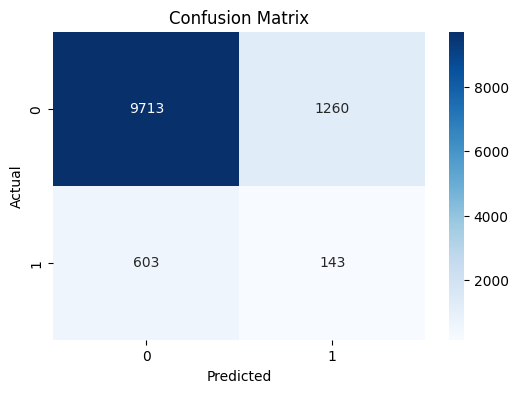

In [185]:
cm = confusion_matrix(y_test, y_pred)
y_test_series = y_test.iloc[:, 0]  # take the first column as Series
classes = sorted(y_test_series.unique())
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [186]:
# save model
joblib.dump(pipeline,'model')

['model']